In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
class TransformerMultiTask(nn.Module):
    def __init__(self, input_dim, num_heads:int, num_layers:int, hidden_dim:int, 
                 entity_id_cls:int, entity_state_cls:int, additional_input_dim:int = 0):
        super(TransformerMultiTask, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
        transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        # Separate heads for classification tasks
        # Simpler actionable classification head
        self.actionable_fc = nn.Linear(hidden_dim + additional_input_dim, 2)
        
        # Head for complex entity ID classification
        self.entity_id_fc = nn.Sequential(
            nn.Linear(hidden_dim + additional_input_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, entity_id_cls)
        )
        
        # Head for entity state classification
        #  - takes the additional inputs and also the outputs of the entity classifications
        self.entity_state_fc = nn.Sequential(
            nn.Linear(hidden_dim + additional_input_dim + entity_id_cls, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, entity_state_cls)
        )
        
        # Regression head for action time prediction
        # - takes the additional inputs and also the outputs of the entity classifications
        self.action_time_regression = nn.Linear(hidden_dim + additional_input_dim + entity_id_cls, 1)

    def forward(self, sequence, additional_inputs=None):
        # x shape: (batch_size, seq_length, input_dim)
        embed = self.embedding(sequence)
        x = self.transformer(embed)
        
        # Take the mean across the sequence dimension
        x = x.mean(dim=1)

        # If additional inputs are provided, concatenate them with x
        if additional_inputs is not None:
            x = torch.cat((x, additional_inputs), dim=-1)
        
        # Separate heads for classification and regression
        actionable_output = self.actionable_fc(x)
        entity_id_output = self.entity_id_fc(x)
        # Concatenate x with entity_id_output before passing to entity_state_fc
        x_with_entity_id = torch.cat((x, entity_id_output), dim=-1)
        entity_state_output = self.entity_state_fc(x_with_entity_id)
        time_pred_output = self.action_time_regression(x_with_entity_id)
        
        # return actionable_output, entity_id_output, entity_state_output, time_pred_output
        return actionable_output, entity_id_output, entity_state_output, time_pred_output

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
import os
import random
import io
import numpy as np
import pandas as pd
import warnings

# Helper function to convert bytes back to tensor
def bytes_to_tensor(tensor_bytes):
    buffer = io.BytesIO(tensor_bytes)
    loaded_tensor = torch.load(buffer, weights_only=True)
    return loaded_tensor

from torch.utils.data import DataLoader

class MultiPartParquetCASASDataset(IterableDataset):
    def __init__(self, file_list, shuffle_files=True, shuffle_rows=True):
        self.file_list = file_list
        self.shuffle_files = shuffle_files
        self.shuffle_rows = shuffle_rows
        
        if self.shuffle_files:
            random.shuffle(self.file_list)  # Shuffle the order of files

    def _read_parquet_file(self, file_path):
        df = pd.read_parquet(file_path)

        if self.shuffle_rows:
            df = df.sample(frac=1).reset_index(drop=True)  # Shuffle rows within the dataframe

        return df

    def __len__(self):
        total_len = 0
        for file in self.file_list:
            df = self._read_parquet_file(file)
            total_len += len(df)
        return total_len
    
    def __iter__(self):
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            for file in self.file_list:
                df = self._read_parquet_file(file)
                for _, row in df.iterrows():
                    # shape(batch_size, sequence_length(var))
                    input_tensor = bytes_to_tensor(row['sequence']) 
                    # additional inputs
                    curr_time_hint_tensors = torch.tensor(row[['min', 'hour', 'day', 'week', 'month']])
                    # y labels
                    time_prediction_tensor = torch.tensor(row['secs_from_last'], dtype=torch.float32)
                    actionable_tensor = torch.tensor(not row['sensor_change'], dtype=torch.long)
                    action_entity_id_tensor = torch.tensor(row['changed_entity_id'], dtype=torch.long)
                    action_entity_state_tensor = torch.tensor(float(row['changed_entity_value']), dtype=torch.long)
    
                    yield input_tensor, curr_time_hint_tensors, time_prediction_tensor, actionable_tensor, action_entity_id_tensor, action_entity_state_tensor


def split_file_list(file_list, train_ratio=0.8, test_ratio=0.1, eval_ratio=0.1):
    """
    Split the list of files into train/test/eval based on the given ratios.
    """
    assert train_ratio + test_ratio + eval_ratio == 1.0, "Ratios must sum to 1"
    
    # Shuffle the file list to ensure randomness
    random.shuffle(file_list)
    
    # Split based on the ratio
    total_files = len(file_list)
    train_end = int(train_ratio * total_files)
    test_end = train_end + int(test_ratio * total_files)
    
    train_files = file_list[:train_end]
    test_files = file_list[train_end:test_end]
    eval_files = file_list[test_end:]
    
    return train_files, test_files, eval_files

def _collate_fn(batch):
    # Separate inputs and targets
    input_tensors, curr_time_hint_tensors, time_prediction_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors = zip(*batch)
    
    # Pad sequences for inputs (batch_first=True makes it [batch_size, seq_len, features])
    input_tensors_padded = pad_sequence(input_tensors, batch_first=True)
    # stack the additional inputs
    curr_time_hint_tensors = torch.stack(curr_time_hint_tensors)
    
    # Convert targets to tensors (they should all have the same length as they're scalar values)
    time_prediction_tensors = torch.stack(time_prediction_tensors)
    actionable_tensors = torch.stack(actionable_tensors)
    action_entity_id_tensors = torch.stack(action_entity_id_tensors)
    action_entity_state_tensors = torch.stack(action_entity_state_tensors)
    
    return input_tensors_padded, curr_time_hint_tensors, time_prediction_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors


In [4]:
import torch
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

def train_act_model(model, dataloader, num_epochs, 
                actionable_classification_criterion, 
                entity_id_classification_criterion, 
                entity_state_classification_criterion, 
                time_pred_regression_criterion, 
                optimizer, device):
    # Store accuracies and time prediction losses
    actionable_accuracies = []
    entity_id_accuracies = []
    entity_state_accuracies = []
    time_losses = []
    
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_entity_state = 0
        total_entity_state = 0
        correct_entity_id = 0
        total_entity_id = 0
        epoch_time_pred_loss = 0
        
        for batch_idx, (input_tensors_padded, curr_time_hint_tensors, time_prediction_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors) in tqdm(enumerate(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Assuming the dataloader returns a dictionary-like batch with relevant keys
            inputs = input_tensors_padded.to(device)  # shape: (batch_size, max_seq_length, input_dim)
            time_hint_inputs = curr_time_hint_tensors.to(device)
            actionable_labels = actionable_tensors.to(device)  # shape: (batch_size,)
            entity_id_labels = action_entity_id_tensors.to(device)  # shape: (batch_size,)
            entity_state_labels = action_entity_state_tensors.to(device)  # shape: (batch_size,)
            time_pred_labels = time_prediction_tensors.to(device)  # shape: (batch_size,)

            optimizer.zero_grad()

            # Forward pass
            actionable_output, entity_id_output, entity_state_output, time_pred_output = model(inputs, additional_inputs=time_hint_inputs)
            
            # Compute losses
            entity_id_loss = entity_id_classification_criterion(entity_id_output, entity_id_labels)
            entity_state_loss = entity_state_classification_criterion(entity_state_output, entity_state_labels)
            time_pred_loss = time_pred_regression_criterion(time_pred_output.squeeze(), time_pred_labels)

            # Total loss
            total_loss = (entity_id_loss * 8 + entity_state_loss * 1.5 + time_pred_loss * 0.5) / 10
            
            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
            # accumulate epoch loss
            epoch_time_pred_loss += time_pred_loss.item()
            
            # Calculate entity ID classification accuracy
            _, predicted_entity_id = torch.max(entity_id_output, 1)
            correct_entity_id += (predicted_entity_id == entity_id_labels).sum().item()
            total_entity_id += entity_id_labels.size(0)

            # Calculate entity state classification accuracy
            _, predicted_entity_state = torch.max(entity_state_output, 1)
            correct_entity_state += (predicted_entity_state == entity_state_labels).sum().item()
            total_entity_state += entity_state_labels.size(0)
            
        # Print epoch stats
        avg_loss = epoch_loss / len(dataloader)
        avg_time_pred_loss = epoch_time_pred_loss / len(dataloader)
        time_losses.append(avg_time_pred_loss)
        entity_id_accuracy = 100 * correct_entity_id / total_entity_id
        entity_id_accuracies.append(entity_id_accuracy)
        entity_state_accuracy = 100 * correct_entity_state / total_entity_state
        entity_state_accuracies.append(entity_state_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Entity ID Acc: {entity_id_accuracy:.4f}%, Entity state Acc: {entity_state_accuracy:.2f}%, Time Pred Loss: {avg_time_pred_loss:.4f}")

    print("Act Training Complete!")
    return actionable_accuracies, entity_id_accuracies, entity_state_accuracies, time_losses

In [5]:
from os import listdir
from os.path import isfile, join
import re
data_root_path = './data/training_act'
data_pattern = r"^training_data_chunk_slim_\d+\.parquet"
file_list = [join(data_root_path, f) for f in listdir(data_root_path) if isfile(join(data_root_path, f)) and re.match(data_pattern, f)][:100]
# Split the file list
train_files, test_files, eval_files = split_file_list(file_list, train_ratio=0.8, test_ratio=0.1, eval_ratio=0.1)

# Create separate datasets
train_dataset = MultiPartParquetCASASDataset(train_files, shuffle_files=True, shuffle_rows=True)
test_dataset = MultiPartParquetCASASDataset(test_files, shuffle_files=False, shuffle_rows=False)
eval_dataset = MultiPartParquetCASASDataset(eval_files, shuffle_files=False, shuffle_rows=False)

# Wrap them in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)


# Actionable Classification Criterion (binary classification)
actionable_classification_criterion = nn.CrossEntropyLoss()

# Entity ID Classification Criterion (multi-class classification)
entity_id_classification_criterion = nn.CrossEntropyLoss()

# Entity State Classification Criterion (multi-class classification)
entity_state_classification_criterion = nn.CrossEntropyLoss()

# Time Prediction Criterion (regression)
time_pred_regression_criterion = nn.MSELoss()



In [6]:
# define the model
model = TransformerMultiTask(input_dim=46, hidden_dim=512, additional_input_dim=5, num_heads=2, num_layers=1, entity_id_cls=45, entity_state_cls=4)
training_epoch = 100
# Using Adam optimizer
import torch.optim as optim
learning_rate = 1e-4  # You can adjust the learning rate as needed
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# find the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# start the training
_, entity_id_accuracies, entity_state_accuracies, time_losses = train_act_model(model=model, dataloader=train_loader, num_epochs=training_epoch, 
            actionable_classification_criterion=actionable_classification_criterion, 
            entity_id_classification_criterion=entity_id_classification_criterion, 
            entity_state_classification_criterion=entity_state_classification_criterion, 
            time_pred_regression_criterion=time_pred_regression_criterion, 
            optimizer=optimizer, device=device)

Epoch 1/100: 15it [00:06,  2.35it/s]


Epoch [1/100], Loss: 2.8102, Entity ID Acc: 13.5593%, Entity state Acc: 50.32%, Time Pred Loss: 0.5227


Epoch 2/100: 15it [00:05,  2.59it/s]


Epoch [2/100], Loss: 2.2706, Entity ID Acc: 16.6314%, Entity state Acc: 54.03%, Time Pred Loss: 0.0965


Epoch 3/100: 15it [00:06,  2.49it/s]


Epoch [3/100], Loss: 2.0846, Entity ID Acc: 19.9153%, Entity state Acc: 53.50%, Time Pred Loss: 0.0506


Epoch 4/100: 15it [00:06,  2.35it/s]


Epoch [4/100], Loss: 1.9773, Entity ID Acc: 20.4449%, Entity state Acc: 52.97%, Time Pred Loss: 0.0788


Epoch 5/100: 15it [00:06,  2.25it/s]


Epoch [5/100], Loss: 1.9286, Entity ID Acc: 21.7161%, Entity state Acc: 50.95%, Time Pred Loss: 0.0771


Epoch 6/100: 15it [00:07,  2.12it/s]


Epoch [6/100], Loss: 1.8658, Entity ID Acc: 23.3051%, Entity state Acc: 57.42%, Time Pred Loss: 0.1286


Epoch 7/100: 15it [00:07,  2.01it/s]


Epoch [7/100], Loss: 1.8001, Entity ID Acc: 27.2246%, Entity state Acc: 59.64%, Time Pred Loss: 0.0948


Epoch 8/100: 15it [00:07,  2.07it/s]


Epoch [8/100], Loss: 1.7905, Entity ID Acc: 26.4831%, Entity state Acc: 59.00%, Time Pred Loss: 0.0429


Epoch 9/100: 15it [00:06,  2.40it/s]


Epoch [9/100], Loss: 1.7635, Entity ID Acc: 27.8602%, Entity state Acc: 63.56%, Time Pred Loss: 0.0354


Epoch 10/100: 15it [00:06,  2.43it/s]


Epoch [10/100], Loss: 1.7335, Entity ID Acc: 28.0720%, Entity state Acc: 63.35%, Time Pred Loss: 0.0415


Epoch 11/100: 15it [00:06,  2.40it/s]


Epoch [11/100], Loss: 1.7093, Entity ID Acc: 30.8263%, Entity state Acc: 62.61%, Time Pred Loss: 0.0196


Epoch 12/100: 15it [00:06,  2.20it/s]


Epoch [12/100], Loss: 1.7038, Entity ID Acc: 30.0847%, Entity state Acc: 63.98%, Time Pred Loss: 0.0187


Epoch 13/100: 15it [00:06,  2.23it/s]


Epoch [13/100], Loss: 1.6926, Entity ID Acc: 29.8729%, Entity state Acc: 62.29%, Time Pred Loss: 0.0240


Epoch 14/100: 15it [00:06,  2.29it/s]


Epoch [14/100], Loss: 1.6462, Entity ID Acc: 32.3093%, Entity state Acc: 62.61%, Time Pred Loss: 0.0219


Epoch 15/100: 15it [00:06,  2.27it/s]


Epoch [15/100], Loss: 1.6418, Entity ID Acc: 32.7331%, Entity state Acc: 62.82%, Time Pred Loss: 0.0133


Epoch 16/100: 15it [00:07,  2.12it/s]


Epoch [16/100], Loss: 1.6268, Entity ID Acc: 33.5805%, Entity state Acc: 62.82%, Time Pred Loss: 0.0132


Epoch 17/100: 15it [00:07,  2.06it/s]


Epoch [17/100], Loss: 1.5835, Entity ID Acc: 34.7458%, Entity state Acc: 65.36%, Time Pred Loss: 0.0134


Epoch 18/100: 15it [00:06,  2.31it/s]


Epoch [18/100], Loss: 1.6066, Entity ID Acc: 33.1568%, Entity state Acc: 63.56%, Time Pred Loss: 0.0142


Epoch 19/100: 15it [00:06,  2.43it/s]


Epoch [19/100], Loss: 1.5246, Entity ID Acc: 37.1822%, Entity state Acc: 64.51%, Time Pred Loss: 0.0142


Epoch 20/100: 15it [00:06,  2.28it/s]


Epoch [20/100], Loss: 1.4973, Entity ID Acc: 39.8305%, Entity state Acc: 62.92%, Time Pred Loss: 0.0452


Epoch 21/100: 15it [00:06,  2.41it/s]


Epoch [21/100], Loss: 1.5358, Entity ID Acc: 36.4407%, Entity state Acc: 64.09%, Time Pred Loss: 0.0270


Epoch 22/100: 15it [00:06,  2.22it/s]


Epoch [22/100], Loss: 1.4143, Entity ID Acc: 42.7966%, Entity state Acc: 64.83%, Time Pred Loss: 0.0766


Epoch 23/100: 15it [00:06,  2.19it/s]


Epoch [23/100], Loss: 1.4601, Entity ID Acc: 39.9364%, Entity state Acc: 63.56%, Time Pred Loss: 0.0531


Epoch 24/100: 15it [00:06,  2.19it/s]


Epoch [24/100], Loss: 1.4039, Entity ID Acc: 43.4322%, Entity state Acc: 61.44%, Time Pred Loss: 0.0461


Epoch 25/100: 15it [00:05,  2.50it/s]


Epoch [25/100], Loss: 1.3354, Entity ID Acc: 46.8220%, Entity state Acc: 66.00%, Time Pred Loss: 0.0644


Epoch 26/100: 15it [00:06,  2.41it/s]


Epoch [26/100], Loss: 1.3201, Entity ID Acc: 48.6229%, Entity state Acc: 65.15%, Time Pred Loss: 0.0554


Epoch 27/100: 15it [00:06,  2.21it/s]


Epoch [27/100], Loss: 1.3026, Entity ID Acc: 47.4576%, Entity state Acc: 66.95%, Time Pred Loss: 0.0920


Epoch 28/100: 15it [00:06,  2.49it/s]


Epoch [28/100], Loss: 1.2537, Entity ID Acc: 50.2119%, Entity state Acc: 66.31%, Time Pred Loss: 0.0309


Epoch 29/100: 15it [00:06,  2.25it/s]


Epoch [29/100], Loss: 1.2537, Entity ID Acc: 48.8347%, Entity state Acc: 66.84%, Time Pred Loss: 0.0688


Epoch 30/100: 15it [00:06,  2.27it/s]


Epoch [30/100], Loss: 1.2328, Entity ID Acc: 49.1525%, Entity state Acc: 67.37%, Time Pred Loss: 0.1506


Epoch 31/100: 15it [00:06,  2.33it/s]


Epoch [31/100], Loss: 1.3133, Entity ID Acc: 45.4449%, Entity state Acc: 65.25%, Time Pred Loss: 0.0894


Epoch 32/100: 15it [00:07,  2.03it/s]


Epoch [32/100], Loss: 1.3138, Entity ID Acc: 46.1864%, Entity state Acc: 63.35%, Time Pred Loss: 0.0917


Epoch 33/100: 15it [00:07,  2.13it/s]


Epoch [33/100], Loss: 1.1927, Entity ID Acc: 52.4364%, Entity state Acc: 67.90%, Time Pred Loss: 0.0689


Epoch 34/100: 15it [00:07,  2.10it/s]


Epoch [34/100], Loss: 1.1269, Entity ID Acc: 54.1314%, Entity state Acc: 69.17%, Time Pred Loss: 0.0695


Epoch 35/100: 15it [00:06,  2.32it/s]


Epoch [35/100], Loss: 1.0997, Entity ID Acc: 55.6144%, Entity state Acc: 70.44%, Time Pred Loss: 0.1980


Epoch 36/100: 15it [00:06,  2.30it/s]


Epoch [36/100], Loss: 1.0710, Entity ID Acc: 54.2373%, Entity state Acc: 70.34%, Time Pred Loss: 0.0789


Epoch 37/100: 15it [00:06,  2.45it/s]


Epoch [37/100], Loss: 1.0934, Entity ID Acc: 53.3898%, Entity state Acc: 72.67%, Time Pred Loss: 0.0320


Epoch 38/100: 15it [00:06,  2.34it/s]


Epoch [38/100], Loss: 0.9869, Entity ID Acc: 59.5339%, Entity state Acc: 71.61%, Time Pred Loss: 0.0658


Epoch 39/100: 15it [00:06,  2.24it/s]


Epoch [39/100], Loss: 0.9794, Entity ID Acc: 61.1229%, Entity state Acc: 75.00%, Time Pred Loss: 0.0651


Epoch 40/100: 15it [00:06,  2.45it/s]


Epoch [40/100], Loss: 0.9514, Entity ID Acc: 63.1356%, Entity state Acc: 74.15%, Time Pred Loss: 0.0293


Epoch 41/100: 15it [00:05,  2.53it/s]


Epoch [41/100], Loss: 0.9731, Entity ID Acc: 61.6525%, Entity state Acc: 74.58%, Time Pred Loss: 0.0228


Epoch 42/100: 15it [00:05,  2.56it/s]


Epoch [42/100], Loss: 0.9492, Entity ID Acc: 62.7119%, Entity state Acc: 74.89%, Time Pred Loss: 0.0202


Epoch 43/100: 15it [00:06,  2.49it/s]


Epoch [43/100], Loss: 0.9457, Entity ID Acc: 61.7585%, Entity state Acc: 76.59%, Time Pred Loss: 0.0119


Epoch 44/100: 15it [00:06,  2.44it/s]


Epoch [44/100], Loss: 0.8546, Entity ID Acc: 66.1017%, Entity state Acc: 80.19%, Time Pred Loss: 0.0093


Epoch 45/100: 15it [00:06,  2.50it/s]


Epoch [45/100], Loss: 0.8675, Entity ID Acc: 66.2076%, Entity state Acc: 77.44%, Time Pred Loss: 0.0137


Epoch 46/100: 15it [00:06,  2.41it/s]


Epoch [46/100], Loss: 0.8328, Entity ID Acc: 65.8898%, Entity state Acc: 77.75%, Time Pred Loss: 0.0318


Epoch 47/100: 15it [00:06,  2.45it/s]


Epoch [47/100], Loss: 0.8316, Entity ID Acc: 65.7839%, Entity state Acc: 79.03%, Time Pred Loss: 0.0260


Epoch 48/100: 15it [00:05,  2.52it/s]


Epoch [48/100], Loss: 0.8811, Entity ID Acc: 64.0890%, Entity state Acc: 78.50%, Time Pred Loss: 0.0396


Epoch 49/100: 15it [00:06,  2.33it/s]


Epoch [49/100], Loss: 0.8123, Entity ID Acc: 65.7839%, Entity state Acc: 80.72%, Time Pred Loss: 0.0190


Epoch 50/100: 15it [00:05,  2.50it/s]


Epoch [50/100], Loss: 0.7664, Entity ID Acc: 67.0551%, Entity state Acc: 79.98%, Time Pred Loss: 0.0057


Epoch 51/100: 15it [00:05,  2.51it/s]


Epoch [51/100], Loss: 0.7490, Entity ID Acc: 70.1271%, Entity state Acc: 80.93%, Time Pred Loss: 0.0046


Epoch 52/100: 15it [00:07,  2.10it/s]


Epoch [52/100], Loss: 0.7619, Entity ID Acc: 67.9025%, Entity state Acc: 81.36%, Time Pred Loss: 0.0046


Epoch 53/100: 15it [00:06,  2.37it/s]


Epoch [53/100], Loss: 0.7263, Entity ID Acc: 69.2797%, Entity state Acc: 82.31%, Time Pred Loss: 0.0060


Epoch 54/100: 15it [00:06,  2.40it/s]


Epoch [54/100], Loss: 0.7389, Entity ID Acc: 70.9746%, Entity state Acc: 78.50%, Time Pred Loss: 0.0057


Epoch 55/100: 15it [00:06,  2.25it/s]


Epoch [55/100], Loss: 0.6904, Entity ID Acc: 71.5042%, Entity state Acc: 81.67%, Time Pred Loss: 0.0046


Epoch 56/100: 15it [00:06,  2.16it/s]


Epoch [56/100], Loss: 0.7267, Entity ID Acc: 70.0212%, Entity state Acc: 85.70%, Time Pred Loss: 0.0086


Epoch 57/100: 15it [00:07,  2.02it/s]


Epoch [57/100], Loss: 0.7042, Entity ID Acc: 70.7627%, Entity state Acc: 83.37%, Time Pred Loss: 0.0068


Epoch 58/100: 15it [00:07,  2.14it/s]


Epoch [58/100], Loss: 0.8205, Entity ID Acc: 63.9831%, Entity state Acc: 81.14%, Time Pred Loss: 0.0034


Epoch 59/100: 15it [00:06,  2.26it/s]


Epoch [59/100], Loss: 0.8503, Entity ID Acc: 63.8771%, Entity state Acc: 80.08%, Time Pred Loss: 0.0056


Epoch 60/100: 15it [00:06,  2.40it/s]


Epoch [60/100], Loss: 0.7215, Entity ID Acc: 68.5381%, Entity state Acc: 83.37%, Time Pred Loss: 0.0051


Epoch 61/100: 15it [00:07,  2.03it/s]


Epoch [61/100], Loss: 0.6696, Entity ID Acc: 69.8093%, Entity state Acc: 87.71%, Time Pred Loss: 0.0038


Epoch 62/100: 15it [00:07,  2.09it/s]


Epoch [62/100], Loss: 0.6729, Entity ID Acc: 71.2924%, Entity state Acc: 85.70%, Time Pred Loss: 0.0060


Epoch 63/100: 15it [00:05,  2.62it/s]


Epoch [63/100], Loss: 0.7051, Entity ID Acc: 70.6568%, Entity state Acc: 79.56%, Time Pred Loss: 0.0077


Epoch 64/100: 15it [00:06,  2.49it/s]


Epoch [64/100], Loss: 0.6392, Entity ID Acc: 72.5636%, Entity state Acc: 88.14%, Time Pred Loss: 0.0164


Epoch 65/100: 15it [00:06,  2.48it/s]


Epoch [65/100], Loss: 0.6090, Entity ID Acc: 75.0000%, Entity state Acc: 89.41%, Time Pred Loss: 0.0075


Epoch 66/100: 15it [00:05,  2.54it/s]


Epoch [66/100], Loss: 0.5999, Entity ID Acc: 74.3644%, Entity state Acc: 88.98%, Time Pred Loss: 0.0048


Epoch 67/100: 15it [00:06,  2.48it/s]


Epoch [67/100], Loss: 0.5794, Entity ID Acc: 74.0466%, Entity state Acc: 89.94%, Time Pred Loss: 0.0041


Epoch 68/100: 15it [00:05,  2.55it/s]


Epoch [68/100], Loss: 0.5922, Entity ID Acc: 74.0466%, Entity state Acc: 88.98%, Time Pred Loss: 0.0028


Epoch 69/100: 15it [00:05,  2.58it/s]


Epoch [69/100], Loss: 0.5914, Entity ID Acc: 74.2585%, Entity state Acc: 91.63%, Time Pred Loss: 0.0023


Epoch 70/100: 15it [00:06,  2.35it/s]


Epoch [70/100], Loss: 0.5904, Entity ID Acc: 73.9407%, Entity state Acc: 84.85%, Time Pred Loss: 0.0025


Epoch 71/100: 15it [00:06,  2.30it/s]


Epoch [71/100], Loss: 0.5508, Entity ID Acc: 75.6356%, Entity state Acc: 90.36%, Time Pred Loss: 0.0023


Epoch 72/100: 15it [00:05,  2.58it/s]


Epoch [72/100], Loss: 0.5413, Entity ID Acc: 78.2839%, Entity state Acc: 90.04%, Time Pred Loss: 0.0020


Epoch 73/100: 15it [00:06,  2.46it/s]


Epoch [73/100], Loss: 0.5530, Entity ID Acc: 76.3771%, Entity state Acc: 91.74%, Time Pred Loss: 0.0021


Epoch 74/100: 15it [00:05,  2.61it/s]


Epoch [74/100], Loss: 0.5359, Entity ID Acc: 76.4831%, Entity state Acc: 91.63%, Time Pred Loss: 0.0019


Epoch 75/100: 15it [00:05,  2.51it/s]


Epoch [75/100], Loss: 0.5143, Entity ID Acc: 77.6483%, Entity state Acc: 91.31%, Time Pred Loss: 0.0021


Epoch 76/100: 15it [00:06,  2.43it/s]


Epoch [76/100], Loss: 0.5141, Entity ID Acc: 78.8136%, Entity state Acc: 91.42%, Time Pred Loss: 0.0025


Epoch 77/100: 15it [00:06,  2.49it/s]


Epoch [77/100], Loss: 0.5201, Entity ID Acc: 77.7542%, Entity state Acc: 91.42%, Time Pred Loss: 0.0027


Epoch 78/100: 15it [00:06,  2.45it/s]


Epoch [78/100], Loss: 0.5336, Entity ID Acc: 76.9068%, Entity state Acc: 91.84%, Time Pred Loss: 0.0029


Epoch 79/100: 15it [00:06,  2.41it/s]


Epoch [79/100], Loss: 0.5294, Entity ID Acc: 77.1186%, Entity state Acc: 92.90%, Time Pred Loss: 0.0029


Epoch 80/100: 15it [00:06,  2.32it/s]


Epoch [80/100], Loss: 0.5459, Entity ID Acc: 76.4831%, Entity state Acc: 92.06%, Time Pred Loss: 0.0023


Epoch 81/100: 15it [00:05,  2.54it/s]


Epoch [81/100], Loss: 0.5566, Entity ID Acc: 75.9534%, Entity state Acc: 90.68%, Time Pred Loss: 0.0042


Epoch 82/100: 15it [00:05,  2.52it/s]


Epoch [82/100], Loss: 0.5185, Entity ID Acc: 78.0720%, Entity state Acc: 88.88%, Time Pred Loss: 0.0046


Epoch 83/100: 15it [00:05,  2.52it/s]


Epoch [83/100], Loss: 0.5044, Entity ID Acc: 78.3898%, Entity state Acc: 91.74%, Time Pred Loss: 0.0045


Epoch 84/100: 15it [00:06,  2.48it/s]


Epoch [84/100], Loss: 0.5331, Entity ID Acc: 77.6483%, Entity state Acc: 91.31%, Time Pred Loss: 0.0025


Epoch 85/100: 15it [00:06,  2.48it/s]


Epoch [85/100], Loss: 0.5018, Entity ID Acc: 78.7076%, Entity state Acc: 91.95%, Time Pred Loss: 0.0027


Epoch 86/100: 15it [00:06,  2.47it/s]


Epoch [86/100], Loss: 0.5039, Entity ID Acc: 78.0720%, Entity state Acc: 90.78%, Time Pred Loss: 0.0044


Epoch 87/100: 15it [00:06,  2.40it/s]


Epoch [87/100], Loss: 0.4786, Entity ID Acc: 78.6017%, Entity state Acc: 92.48%, Time Pred Loss: 0.0047


Epoch 88/100: 15it [00:05,  2.53it/s]


Epoch [88/100], Loss: 0.4986, Entity ID Acc: 78.0720%, Entity state Acc: 90.57%, Time Pred Loss: 0.0037


Epoch 89/100: 15it [00:05,  2.59it/s]


Epoch [89/100], Loss: 0.4939, Entity ID Acc: 77.7542%, Entity state Acc: 89.72%, Time Pred Loss: 0.0042


Epoch 90/100: 15it [00:06,  2.44it/s]


Epoch [90/100], Loss: 0.4591, Entity ID Acc: 79.0254%, Entity state Acc: 91.21%, Time Pred Loss: 0.0027


Epoch 91/100: 15it [00:06,  2.43it/s]


Epoch [91/100], Loss: 0.4480, Entity ID Acc: 80.5085%, Entity state Acc: 92.16%, Time Pred Loss: 0.0034


Epoch 92/100: 15it [00:06,  2.50it/s]


Epoch [92/100], Loss: 0.5097, Entity ID Acc: 77.7542%, Entity state Acc: 90.89%, Time Pred Loss: 0.0029


Epoch 93/100: 15it [00:06,  2.49it/s]


Epoch [93/100], Loss: 0.4521, Entity ID Acc: 80.1907%, Entity state Acc: 93.96%, Time Pred Loss: 0.0033


Epoch 94/100: 15it [00:05,  2.51it/s]


Epoch [94/100], Loss: 0.4732, Entity ID Acc: 79.8729%, Entity state Acc: 91.00%, Time Pred Loss: 0.0023


Epoch 95/100: 15it [00:06,  2.18it/s]


Epoch [95/100], Loss: 0.4893, Entity ID Acc: 79.1314%, Entity state Acc: 90.78%, Time Pred Loss: 0.0029


Epoch 96/100: 15it [00:05,  2.53it/s]


Epoch [96/100], Loss: 0.4385, Entity ID Acc: 80.5085%, Entity state Acc: 91.63%, Time Pred Loss: 0.0031


Epoch 97/100: 15it [00:06,  2.48it/s]


Epoch [97/100], Loss: 0.4278, Entity ID Acc: 82.5212%, Entity state Acc: 93.54%, Time Pred Loss: 0.0025


Epoch 98/100: 15it [00:06,  2.47it/s]


Epoch [98/100], Loss: 0.4034, Entity ID Acc: 81.8856%, Entity state Acc: 94.07%, Time Pred Loss: 0.0020


Epoch 99/100: 15it [00:06,  2.21it/s]


Epoch [99/100], Loss: 0.3918, Entity ID Acc: 82.2034%, Entity state Acc: 95.66%, Time Pred Loss: 0.0022


Epoch 100/100: 15it [00:07,  2.10it/s]


Epoch [100/100], Loss: 0.3898, Entity ID Acc: 81.7797%, Entity state Acc: 95.66%, Time Pred Loss: 0.0019
Act Training Complete!


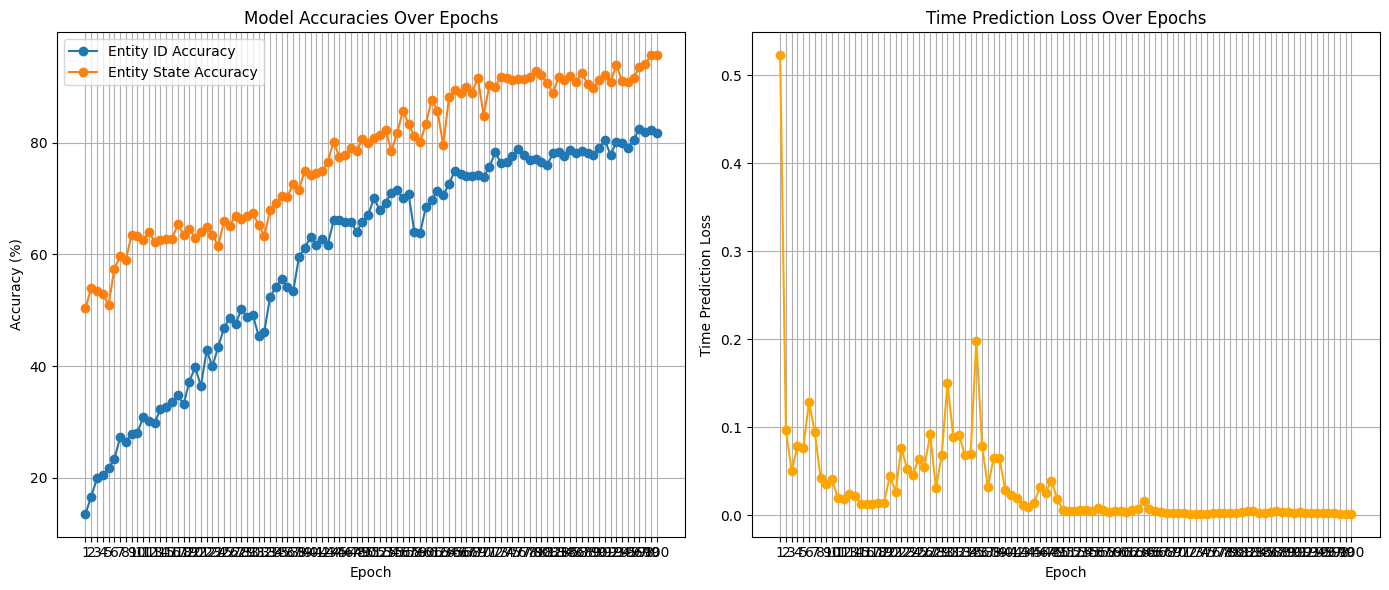

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, training_epoch + 1), entity_id_accuracies, marker='o', label='Entity ID Accuracy')
plt.plot(range(1, training_epoch + 1), entity_state_accuracies, marker='o', label='Entity State Accuracy')
plt.title('Model Accuracies Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, training_epoch + 1))  # Set x-ticks to match epoch numbers
plt.legend()
plt.grid()

# Plot time prediction loss
plt.subplot(1, 2, 2)
plt.plot(range(1, training_epoch + 1), time_losses, marker='o', color='orange')
plt.title('Time Prediction Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Time Prediction Loss')
plt.xticks(range(1, training_epoch + 1))  # Set x-ticks to match epoch numbers
plt.grid()

plt.tight_layout()
plt.show()

In [10]:
torch.save(model.state_dict(), 'transformer_multi_task_slim.pth')

In [11]:
loaded_model = TransformerMultiTask(input_dim=46, hidden_dim=512, additional_input_dim=5, num_heads=2, num_layers=1, entity_id_cls=45, entity_state_cls=4)
# Load the state dict
loaded_model.load_state_dict(torch.load('transformer_multi_task_slim.pth', weights_only=True))
loaded_model.eval()  # Set the model to evaluation mode

TransformerMultiTask(
  (embedding): Linear(in_features=46, out_features=512, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (actionable_fc): Linear(in_features=517, out_features=2, bias=True)
  (entity_id_fc): Sequential(
    (0): Linear(in_features=517, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=